# **Báo cáo Project Deep Learning: Phân loại ảnh với Vision Transformer (ViT)**

**Sinh viên thực hiện:** (Tên của bạn)
**Môn học:** Deep Learning
**Đề tài:** ViT Image Classification

---

## **Mục tiêu Project**

Project này nhằm mục đích xây dựng và huấn luyện một mô hình Vision Transformer (ViT) để giải quyết bài toán phân loại hình ảnh. Các mục tiêu cụ thể bao gồm:

1.  **Xây dựng mô hình ViT:** Tự triển khai các thành phần cốt lõi của ViT, bao gồm Patch Embedding và Transformer Encoder.
2.  **Huấn luyện và Đánh giá:** Huấn luyện mô hình trên bộ dữ liệu CIFAR-100 và đánh giá hiệu năng của nó.
3.  **So sánh với CNN:** So sánh hiệu năng của mô hình ViT với một mô hình Mạng nơ-ron tích chập (CNN) có số lượng tham số tương đương.
4.  **Trực quan hóa Attention:** Trực quan hóa bản đồ chú ý (attention maps) để hiểu cách mô hình "nhìn" và tập trung vào các vùng quan trọng của ảnh khi đưa ra dự đoán.

**Dataset:** Chúng ta sẽ sử dụng bộ dữ liệu **CIFAR-100**. Đây là một bộ dữ liệu phổ biến, bao gồm 60,000 ảnh màu kích thước 32x32, được chia thành 100 lớp. Mỗi lớp có 600 ảnh.

---

### **Cài đặt và Imports**

Đầu tiên, chúng ta cần import các thư viện cần thiết. Chúng ta sẽ sử dụng `torch` và `torchvision` để xây dựng, huấn luyện mô hình và xử lý dữ liệu. `matplotlib` và `seaborn` sẽ được dùng để trực quan hóa dữ liệu và kết quả. `tqdm` giúp tạo thanh tiến trình (progress bar) đẹp mắt khi huấn luyện.


In [1]:
# Import các thư viện cần thiết
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time

# Thiết lập device (sử dụng GPU nếu có)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng device: {device}")


Sử dụng device: cpu


### **Tải và Tiền xử lý Dữ liệu (CIFAR-100)**

Ở bước này, chúng ta sẽ định nghĩa các phép biến đổi (transformations) cho dữ liệu. Đối với ViT, kích thước ảnh đầu vào thường lớn hơn so với 32x32 của CIFAR-100, vì vậy chúng ta sẽ resize ảnh lên 224x224. Data Augmentation (như lật ngẫu nhiên, cắt ngẫu nhiên) cũng được áp dụng cho tập huấn luyện để giúp mô hình tổng quát hóa tốt hơn.


In [2]:
# Định nghĩa các phép biến đổi cho dữ liệu
# Kích thước ảnh đầu vào cho ViT thường là 224x224
image_size = 224

# Biến đổi cho tập huấn luyện (có data augmentation)
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomCrop(image_size, padding=28), # Padding tương đương ~1/8 kích thước ảnh
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# Biến đổi cho tập kiểm tra (không có data augmentation)
transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# Tải dataset CIFAR-100
train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Tạo DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Lấy tên các lớp
classes = train_dataset.classes
print(f"Số lượng lớp: {len(classes)}")

Số lượng lớp: 100


### **Trực quan hóa một vài ảnh trong Dataset**

Để hiểu rõ hơn về dữ liệu, chúng ta hãy hiển thị một vài ảnh ngẫu nhiên từ tập huấn luyện cùng với nhãn của chúng.


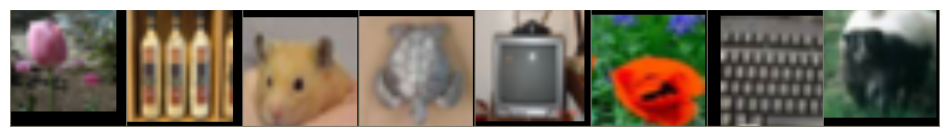

Nhãn: tulip bottle hamster turtle television poppy keyboard skunk


In [3]:
def imshow(img):
    """Hàm để hiển thị ảnh"""
    # Unnormalize ảnh
    mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
    std = torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1)
    img = img * std + mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Lấy một batch ảnh
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Hiển thị ảnh
plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images[:8]))
plt.show()

# In nhãn tương ứng
print('Nhãn:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

## **Phần 1: Xây dựng mô hình Vision Transformer (ViT)**

ViT xử lý ảnh bằng cách chia nó thành các "patch" (mảnh) nhỏ, biến mỗi patch thành một vector và đưa chuỗi vector này vào một Transformer Encoder tiêu chuẩn.

### **Lớp Patch Embedding**

Lớp này có nhiệm vụ:
1.  Sử dụng một lớp tích chập (`Conv2d`) để chia ảnh thành các patch và biến chúng thành các vector embedding.
2.  Làm phẳng (flatten) output để tạo ra một chuỗi các token.
3.  Thêm một token đặc biệt `[CLS]` vào đầu chuỗi, token này sẽ được dùng để phân loại.
4.  Thêm `Positional Embedding` để cung cấp thông tin về vị trí của các patch.


In [4]:
class PatchEmbedding(nn.Module):
    """Chuyển ảnh thành chuỗi các patch embeddings."""
    def __init__(self, image_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2
        
        # Lớp Conv2d để tạo patch và embedding
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        # Token [CLS] để phân loại
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Positional embedding để mã hóa vị trí
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        batch_size = x.shape[0]
        
        # (B, C, H, W) -> (B, D, H/P, W/P) -> (B, D, N) -> (B, N, D)
        x = self.projection(x).flatten(2).transpose(1, 2)
        
        # Thêm token [CLS] vào đầu chuỗi
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Thêm positional embedding
        x = x + self.positional_embedding
        return x

### **Lớp Transformer Encoder**

Đây là trái tim của mô hình ViT, bao gồm các khối `Multi-Head Self-Attention` và `Feed-Forward Network` (MLP).


In [5]:
class TransformerEncoderBlock(nn.Module):
    """Một khối trong Transformer Encoder."""
    def __init__(self, embed_dim=768, num_heads=12, mlp_dim=3072, dropout=0.1):
        super().__init__()
        # Lớp chuẩn hóa LayerNorm
        self.norm1 = nn.LayerNorm(embed_dim)
        # Lớp Multi-Head Attention
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        # Lớp MLP (Feed-Forward Network)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Skip connection 1
        x_norm1 = self.norm1(x)
        attn_output, _ = self.attention(x_norm1, x_norm1, x_norm1)
        x = x + attn_output
        
        # Skip connection 2
        x_norm2 = self.norm2(x)
        mlp_output = self.mlp(x_norm2)
        x = x + mlp_output
        
        return x

### **Xây dựng mô hình ViT hoàn chỉnh**

Bây giờ, chúng ta sẽ kết hợp các thành phần trên để tạo ra mô hình ViT hoàn chỉnh. Mô hình sẽ bao gồm lớp `PatchEmbedding`, theo sau là nhiều lớp `TransformerEncoderBlock` và cuối cùng là một `MLP Head` để phân loại.


In [6]:
class VisionTransformer(nn.Module):
    """Mô hình Vision Transformer."""
    def __init__(self, image_size=224, patch_size=16, in_channels=3, embed_dim=768, num_heads=12, mlp_dim=3072, num_layers=12, num_classes=100, dropout=0.1):
        super().__init__()
        # 1. Patch Embedding
        self.patch_embed = PatchEmbedding(image_size, patch_size, in_channels, embed_dim)
        
        # 2. Transformer Encoder
        self.encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ])
        
        # 3. Lớp chuẩn hóa cuối cùng
        self.norm = nn.LayerNorm(embed_dim)
        
        # 4. MLP Head để phân loại
        self.mlp_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Chuyển ảnh thành chuỗi patch embeddings
        x = self.patch_embed(x)
        
        # Đưa qua các khối Transformer Encoder
        for block in self.encoder_blocks:
            x = block(x)
            
        # Lấy output của token [CLS] (token đầu tiên)
        cls_token_output = self.norm(x[:, 0])
        
        # Đưa qua MLP Head để ra kết quả phân loại
        output = self.mlp_head(cls_token_output)
        
        return output

### **Khởi tạo mô hình ViT, Định nghĩa hàm mất mát và Optimizer**

Chúng ta sẽ tạo một phiên bản "nhỏ" của ViT để phù hợp với việc huấn luyện trên các máy tính cá nhân.


In [7]:
# Cấu hình cho một phiên bản ViT "Tiny"
vit_config_tiny = {
    "embed_dim": 192,
    "num_heads": 3,
    "mlp_dim": 768, # 4 * embed_dim
    "num_layers": 12,
    "patch_size": 16
}

# Khởi tạo mô hình ViT
vit_model = VisionTransformer(
    image_size=image_size,
    patch_size=vit_config_tiny["patch_size"],
    embed_dim=vit_config_tiny["embed_dim"],
    num_heads=vit_config_tiny["num_heads"],
    mlp_dim=vit_config_tiny["mlp_dim"],
    num_layers=vit_config_tiny["num_layers"],
    num_classes=len(classes)
).to(device)

# Đếm số lượng tham số
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Số lượng tham số của ViT: {count_parameters(vit_model):,}")

# Định nghĩa hàm mất mát và optimizer
criterion = nn.CrossEntropyLoss()
optimizer_vit = optim.Adam(vit_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_vit = optim.lr_scheduler.StepLR(optimizer_vit, step_size=10, gamma=0.1)

Số lượng tham số của ViT: 5,543,716


### **Các hàm Huấn luyện và Đánh giá**

Chúng ta sẽ viết các hàm `train_epoch` và `evaluate` để tổ chức code một cách sạch sẽ.


In [8]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Hàm huấn luyện một epoch."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    """Hàm đánh giá mô hình."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

### **Vòng lặp Huấn luyện chính cho ViT**

Bây giờ, hãy bắt đầu huấn luyện mô hình ViT. Quá trình này có thể mất khá nhiều thời gian tùy thuộc vào phần cứng của bạn.


In [ ]:
num_epochs = 20 # Giảm số epochs nếu thời gian hạn hẹp
history_vit = {
    'train_loss': [], 'train_acc': [],
    'test_loss': [], 'test_acc': []
}

print("Bắt đầu huấn luyện mô hình ViT...")
start_time = time.time()

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(vit_model, train_loader, criterion, optimizer_vit, device)
    test_loss, test_acc = evaluate(vit_model, test_loader, criterion, device)
    
    scheduler_vit.step()
    
    history_vit['train_loss'].append(train_loss)
    history_vit['train_acc'].append(train_acc)
    history_vit['test_loss'].append(test_loss)
    history_vit['test_acc'].append(test_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

end_time = time.time()
print(f"Hoàn thành huấn luyện ViT trong {(end_time - start_time)/60:.2f} phút.")

Bắt đầu huấn luyện mô hình ViT...


Training:   0%|          | 0/782 [00:00<?, ?it/s]

### **Trực quan hóa kết quả Huấn luyện ViT**

Vẽ biểu đồ loss và accuracy qua các epoch để đánh giá quá trình học của mô hình.


In [ ]:
def plot_history(history, model_name):
    """Vẽ biểu đồ loss và accuracy."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Vẽ biểu đồ Accuracy
    ax1.plot(history['train_acc'], label='Train Accuracy', color='blue', marker='o')
    ax1.plot(history['test_acc'], label='Test Accuracy', color='orange', marker='s')
    ax1.set_title(f'{model_name} - Accuracy qua các Epochs', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend()
    ax1.grid(True)

    # Vẽ biểu đồ Loss
    ax2.plot(history['train_loss'], label='Train Loss', color='blue', marker='o')
    ax2.plot(history['test_loss'], label='Test Loss', color='orange', marker='s')
    ax2.set_title(f'{model_name} - Loss qua các Epochs', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_history(history_vit, "Vision Transformer")

## **Phần 2: So sánh ViT với CNN**

Để có một sự so sánh công bằng, chúng ta sẽ xây dựng một mô hình CNN đơn giản và cố gắng giữ cho số lượng tham số của nó gần bằng với mô hình ViT mà chúng ta đã xây dựng.

### **Xây dựng mô hình CNN**

Đây là một kiến trúc CNN cơ bản với các lớp Conv2d, BatchNorm, ReLU, MaxPool và các lớp Fully Connected.


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # Input: 3 x 224 x 224
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112x112
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28x28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14x14

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 7x7
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Khởi tạo mô hình CNN
cnn_model = SimpleCNN(num_classes=len(classes)).to(device)
print(f"Số lượng tham số của CNN: {count_parameters(cnn_model):,}")

# Định nghĩa optimizer và scheduler cho CNN
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)
scheduler_cnn = optim.lr_scheduler.StepLR(optimizer_cnn, step_size=10, gamma=0.1)

### **Huấn luyện mô hình CNN**

Chúng ta sẽ huấn luyện CNN với cùng số epoch và cùng bộ dữ liệu như ViT.


In [ ]:
history_cnn = {
    'train_loss': [], 'train_acc': [],
    'test_loss': [], 'test_acc': []
}

print("Bắt đầu huấn luyện mô hình CNN...")
start_time = time.time()

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(cnn_model, train_loader, criterion, optimizer_cnn, device)
    test_loss, test_acc = evaluate(cnn_model, test_loader, criterion, device)
    
    scheduler_cnn.step()
    
    history_cnn['train_loss'].append(train_loss)
    history_cnn['train_acc'].append(train_acc)
    history_cnn['test_loss'].append(test_loss)
    history_cnn['test_acc'].append(test_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

end_time = time.time()
print(f"Hoàn thành huấn luyện CNN trong {(end_time - start_time)/60:.2f} phút.")

### **So sánh kết quả**

Hãy vẽ biểu đồ kết quả của cả hai mô hình để so sánh trực tiếp.


In [ ]:
# Vẽ biểu đồ Accuracy
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid')
plt.plot(history_vit['test_acc'], label='ViT Test Accuracy', color='blue', marker='o')
plt.plot(history_cnn['test_acc'], label='CNN Test Accuracy', color='red', marker='s')
plt.title('So sánh Độ chính xác: ViT vs. CNN', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

print(f"Độ chính xác cuối cùng của ViT trên tập test: {history_vit['test_acc'][-1]:.4f}")
print(f"Độ chính xác cuối cùng của CNN trên tập test: {history_cnn['test_acc'][-1]:.4f}")

## **Phần 3: Trực quan hóa Attention Maps**

Phần mở rộng này sẽ giúp chúng ta hiểu được mô hình ViT đang "tập trung" vào đâu trong ảnh khi đưa ra quyết định. Chúng ta sẽ trích xuất trọng số attention từ khối Transformer cuối cùng.

### **Chỉnh sửa mô hình để lấy Attention Map**

Chúng ta cần chỉnh sửa lại lớp `TransformerEncoderBlock` một chút để nó trả về cả trọng số attention.


In [ ]:
class TransformerEncoderBlockWithAttention(nn.Module):
    """Transformer Encoder Block trả về cả attention weights."""
    def __init__(self, embed_dim=768, num_heads=12, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(), nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x_norm1 = self.norm1(x)
        # Lấy attention weights (attn_output_weights)
        attn_output, attn_weights = self.attention(x_norm1, x_norm1, x_norm1)
        x = x + attn_output
        x_norm2 = self.norm2(x)
        mlp_output = self.mlp(x_norm2)
        x = x + mlp_output
        return x, attn_weights

class VisionTransformerWithAttention(VisionTransformer):
    """ViT trả về attention weights của khối cuối cùng."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Thay thế khối encoder cuối cùng bằng phiên bản có trả về attention
        self.encoder_blocks[-1] = TransformerEncoderBlockWithAttention(
            embed_dim=kwargs["embed_dim"], num_heads=kwargs["num_heads"], 
            mlp_dim=kwargs["mlp_dim"], dropout=kwargs.get("dropout", 0.1)
        )
    
    def forward_with_attention(self, x):
        x = self.patch_embed(x)
        
        # Đưa qua các khối encoder, trừ khối cuối
        for i in range(len(self.encoder_blocks) - 1):
            x = self.encoder_blocks[i](x)
        
        # Đưa qua khối cuối cùng để lấy attention
        x, attn_weights = self.encoder_blocks[-1](x)
        
        cls_token_output = self.norm(x[:, 0])
        output = self.mlp_head(cls_token_output)
        return output, attn_weights

# Tạo một mô hình mới để lấy attention (có thể load lại trọng số đã train)
vit_attn_model = VisionTransformerWithAttention(
    image_size=image_size,
    patch_size=vit_config_tiny["patch_size"],
    embed_dim=vit_config_tiny["embed_dim"],
    num_heads=vit_config_tiny["num_heads"],
    mlp_dim=vit_config_tiny["mlp_dim"],
    num_layers=vit_config_tiny["num_layers"],
    num_classes=len(classes)
).to(device)

# Load lại trọng số từ mô hình đã huấn luyện
vit_attn_model.load_state_dict(vit_model.state_dict())
vit_attn_model.eval()
print("Mô hình ViT để lấy attention đã sẵn sàng.")

### **Hàm trực quan hóa Attention Map**

Hàm này sẽ nhận một ảnh, đưa qua mô hình, xử lý các trọng số attention và vẽ chúng chồng lên ảnh gốc.


In [ ]:
def visualize_attention(model, image_tensor, patch_size, device):
    """Hàm trực quan hóa attention map."""
    # Unnormalize ảnh để hiển thị
    mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(1, 3, 1, 1)
    std = torch.tensor([0.2675, 0.2565, 0.2761]).view(1, 3, 1, 1)
    image_for_plot = image_tensor.cpu() * std + mean
    image_for_plot = image_for_plot.squeeze(0).permute(1, 2, 0)
    
    # Thêm batch dimension và đưa lên device
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output, attention = model.forward_with_attention(image_tensor)
        
    # Lấy attention của token CLS tới các patch khác
    cls_attention = attention[0, :, 0, 1:].reshape(model.patch_embed.num_patches, -1)
    
    # Trung bình attention qua các head
    cls_attention = cls_attention.mean(axis=1)
    
    # Reshape attention map về kích thước 2D
    num_patches_side = int(model.patch_embed.num_patches ** 0.5)
    attention_map = cls_attention.reshape(num_patches_side, num_patches_side).cpu().numpy()
    
    # Resize attention map về kích thước ảnh gốc
    attention_map_resized = torch.from_numpy(attention_map).unsqueeze(0).unsqueeze(0)
    attention_map_resized = F.interpolate(attention_map_resized, scale_factor=patch_size, mode="bilinear").squeeze().numpy()
    
    # Vẽ
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image_for_plot)
    ax1.set_title("Ảnh gốc")
    ax1.axis('off')
    
    ax2.imshow(image_for_plot)
    ax2.imshow(attention_map_resized, cmap='jet', alpha=0.5) # Chồng attention map lên ảnh
    ax2.set_title("Attention Map")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # In ra dự đoán
    prediction = torch.argmax(output, dim=1).item()
    print(f"Dự đoán của mô hình: {classes[prediction]}")

# Lấy một vài ảnh từ tập test để visualize
for i in range(5):
    image, label = test_dataset[i * 100] # Lấy các ảnh cách xa nhau
    print(f"\n--- Ảnh {i+1} ---")
    print(f"Nhãn thực tế: {classes[label]}")
    visualize_attention(vit_attn_model, image, vit_config_tiny["patch_size"], device)

## **Kết luận và Phân tích**

Trong phần này, bạn sẽ viết ra những nhận xét của mình dựa trên kết quả thu được:

1.  **Hiệu năng của ViT:**
    *   Mô hình ViT đạt được độ chính xác là bao nhiêu trên tập test?
    *   Phân tích biểu đồ loss và accuracy: Mô hình có dấu hiệu overfitting không? Quá trình hội tụ diễn ra như thế nào?

2.  **So sánh ViT và CNN:**
    *   Mô hình nào hoạt động tốt hơn trên bộ dữ liệu CIFAR-100 với cùng điều kiện huấn luyện?
    *   Dựa trên lý thuyết, tại sao ViT thường cần nhiều dữ liệu hơn CNN để đạt hiệu năng tốt? (Gợi ý: inductive bias). Trong project này, kết quả có phản ánh điều đó không?
    *   So sánh về thời gian huấn luyện và số lượng tham số.

3.  **Phân tích Attention Maps:**
    *   Nhìn vào các attention map, mô hình có thực sự tập trung vào đối tượng chính trong ảnh không?
    *   Có trường hợp nào mô hình tập trung vào nền hoặc các chi tiết không liên quan không? Điều này nói lên điều gì về cách mô hình "suy luận"?

4.  **Hướng phát triển:**
    *   Có thể cải thiện hiệu năng của ViT bằng cách nào? (ví dụ: dùng mô hình pre-trained trên ImageNet, sử dụng data augmentation mạnh hơn, tinh chỉnh learning rate scheduler...).
